## Модули

In [1]:
import keras
from keras.datasets import fashion_mnist
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

import cv2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

## Загрузка данных

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print("Параметры обучающего набора данных:")
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_train.dtype = {X_train.dtype}")
print(f"y_train.dtype = {y_train.dtype}\n")

print("Параметры тестового набора данных:")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")
print(f"X_test.dtype = {X_test.dtype}")
print(f"y_test.dtype = {y_test.dtype}")

Параметры обучающего набора данных:
X_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
X_train.dtype = uint8
y_train.dtype = uint8

Параметры тестового набора данных:
X_test.shape = (10000, 28, 28)
y_test.shape = (10000,)
X_test.dtype = uint8
y_test.dtype = uint8


In [4]:
print(f"Классы обучающего набора данных: {np.unique(y_train)}")
print(
    f"Количество элементов каждого класса в обучающем наборе {np.unique(y_train, return_counts=True)[1]}\n"
)

print(f"Классы тестового набора данных: {np.unique(y_test)}")
print(
    f"Количество элементов каждого класса в тестовом наборе {np.unique(y_test, return_counts=True)[1]}"
)

Классы обучающего набора данных: [0 1 2 3 4 5 6 7 8 9]
Количество элементов каждого класса в обучающем наборе [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]

Классы тестового набора данных: [0 1 2 3 4 5 6 7 8 9]
Количество элементов каждого класса в тестовом наборе [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [5]:
label_description = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
print(f"Расшифровка меток классов: {label_description}")

Расшифровка меток классов: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


Можно видеть, что набор данных состоит из числовых значений, содержит 10 различных классов и является сбалансированным.

In [6]:
print(
    f"Наличие дубликатов в X_train: {(np.unique(X_train, return_counts=True, axis=0)[1] > 1).any()}"
)
print(
    f"Наличие дубликатов в X_test: {(np.unique(X_test, return_counts=True, axis=0)[1] > 1).any()}"
)

Наличие дубликатов в X_train: False
Наличие дубликатов в X_test: False


In [7]:
print(f"Наличие пропусков в X_train: {np.isin(X_train, [None, np.nan]).any()}")
print(f"Наличие пропусков в y_train: {np.isin(y_train, [None, np.nan]).any()}\n")

print(f"Наличие пропусков в X_test: {np.isin(X_test, [None, np.nan]).any()}")
print(f"Наличие пропусков в y_test: {np.isin(y_test, [None, np.nan]).any()}")

Наличие пропусков в X_train: False
Наличие пропусков в y_train: False

Наличие пропусков в X_test: False
Наличие пропусков в y_test: False


В наборе данных отсутствуют дубликаты и пропуски.

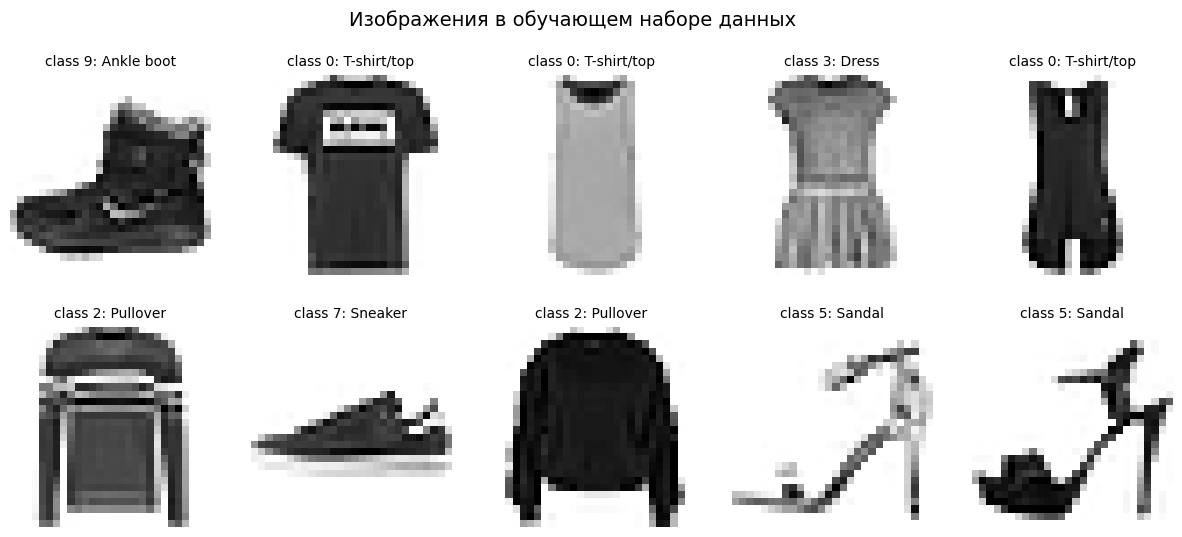

In [8]:
# Отрисовка первых десяти примеров с метками классов
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle("Изображения в обучающем наборе данных", fontsize=14)
for idx, (i, j) in zip(range(10), [(i, j) for i in range(2) for j in range(5)]):
    axs[i, j].imshow(X_train[idx], cmap="binary")
    axs[i, j].set_title(
        f"class {y_train[idx]}: {label_description[y_train[idx]]}", fontsize=10
    )
    axs[i, j].axis("off")

In [9]:
# Приведем данные к масштабу [0, 1] для использования в качестве входных данных нейронных сетей
X_train = X_train.astype("float32") / X_train.max()
X_test = X_test.astype("float32") / X_test.max()

print(f"Диапазон значений X_train: {X_train.min()} - {X_train.max()}")
print(f"Диапазон значений X_test: {X_test.min()} - {X_test.max()}")

Диапазон значений X_train: 0.0 - 1.0
Диапазон значений X_test: 0.0 - 1.0


## Обучение моделей

Сравним особенности классификации, произведенной с помощью "широких" и "глубоких" моделей нейронных сетей, с примерно равным количеством параметров. К "широким" нейронным сетям относятся модели, в которых большое количество нейрононов (или сверточных фильтров) в слое, но малое количество слоев. А к "глубоким", модели, у которых большее количество слоев, но меньшее количество нейронов в каждом слое.

In [10]:
INPUT_SHAPE = (X_train.shape[1], X_train.shape[2], 1)
N_CLASSES = np.unique(y_train).shape[0]
N_EPOCHS = 50
BATCH_SIZE = 256

In [11]:
# Отображение истории обученя
def show_history(history_obj, comment_txt):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f"{comment_txt}")

    axs[0].plot(history_obj.history["accuracy"])
    axs[0].plot(history_obj.history["val_accuracy"])
    axs[0].hlines(0.9, 0, 50, color="r")
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(["train", "test", "accuracy target"], loc="lower right")
    axs[0].set_ylim([0.8, 1])

    axs[1].plot(history_obj.history["loss"])
    axs[1].plot(history_obj.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(["train", "test"], loc="lower left")
    axs[1].set_ylim([0, 0.7])

    plt.show()

### Полносвязанная нейронная сеть

In [12]:
# "Широкая" полносвязанная нейронная сеть
model_fc_wide = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE),
        Flatten(),
        Dense(4096, activation="relu"),
        Dense(N_CLASSES, activation="softmax"),
    ],
    name="model_fc_wide",
)

model_fc_wide.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model_fc_wide.summary()

Model: "model_fc_wide"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 4096)              3215360   
                                                                 
 dense_1 (Dense)             (None, 10)                40970     
                                                                 
Total params: 3,256,330
Trainable params: 3,256,330
Non-trainable params: 0
_________________________________________________________________


In [13]:
history_fc_wide = model_fc_wide.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    verbose=0,
)

print("model_fc_wide:")
print(
    f"max_val_accuracy = {round(max(history_fc_wide.history.get('val_accuracy')), 4)}",
    end=" ",
)
print(
    f"on Epoch {np.argmax(history_fc_wide.history.get('val_accuracy')) + 1}/{N_EPOCHS}"
)

model_fc_wide:
max_val_accuracy = 0.9018 on Epoch 39/50


In [14]:
# "Глубокая" полносвязанная нейронная сеть
model_fc_deep = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE),
        Flatten(),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(256, activation="relu"),
        Dense(N_CLASSES, activation="softmax"),
    ],
    name="model_fc_deep",
)

model_fc_deep.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model_fc_deep.summary()

Model: "model_fc_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              803840    
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dense_6 (Dense)             (None, 10)                2570      
                                                                 
Total params: 3,168,010
Trainable params: 3,168,010
N

In [15]:
history_fc_deep = model_fc_deep.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    verbose=0,
)

print("model_fc_deep:")
print(
    f"max_val_accuracy = {round(max(history_fc_deep.history.get('val_accuracy')), 4)}",
    end=" ",
)
print(
    f"on Epoch {np.argmax(history_fc_deep.history.get('val_accuracy')) + 1}/{N_EPOCHS}"
)

model_fc_deep:
max_val_accuracy = 0.9006 on Epoch 49/50


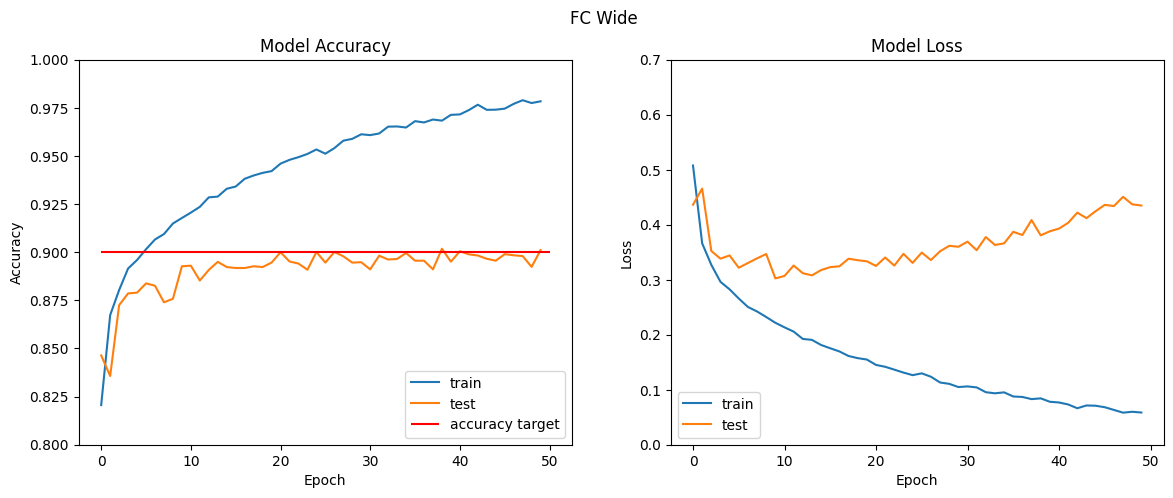

In [16]:
show_history(history_fc_wide, "FC Wide")

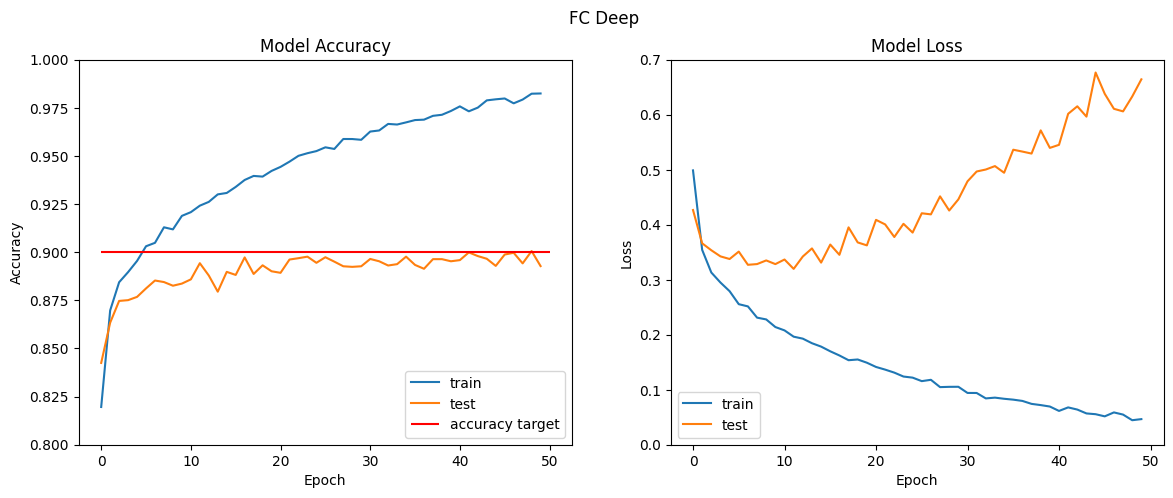

In [17]:
show_history(history_fc_deep, "FC Deep")

Можно видеть, что обе модели дают примерно равные значения Accuracy, достигающие 90%, однако "глубокая" полносвязанная нейронная сеть имеет большую тенденцию к переобучению, чем "широкая".

### Сверточная нейронная сеть

In [18]:
# "Широкая" сверточная нейронная сеть
model_cnn_wide = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        MaxPooling2D((2, 2), strides=2),
        Conv2D(128, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(128, padding="same", kernel_size=(3, 3), activation="relu"),
        MaxPooling2D((2, 2), strides=2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(N_CLASSES, activation="softmax"),
    ],
    name="model_cnn_wide",
)

model_cnn_wide.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model_cnn_wide.summary()

Model: "model_cnn_wide"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                

In [19]:
history_cnn_wide = model_cnn_wide.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    verbose=0,
)

print("model_cnn_wide:")
print(
    f"max_val_accuracy = {round(max(history_cnn_wide.history.get('val_accuracy')), 4)}",
    end=" ",
)
print(
    f"on Epoch {np.argmax(history_cnn_wide.history.get('val_accuracy')) + 1}/{N_EPOCHS}"
)

model_cnn_wide:
max_val_accuracy = 0.9325 on Epoch 15/50


In [20]:
# "Глубокая" сверточная нейронная сеть
model_cnn_deep = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(32, padding="same", kernel_size=(3, 3), activation="relu"),
        MaxPooling2D((2, 2), strides=2),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        Conv2D(64, padding="same", kernel_size=(3, 3), activation="relu"),
        MaxPooling2D((2, 2), strides=2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(N_CLASSES, activation="softmax"),
    ],
    name="model_cnn_deep",
)

model_cnn_deep.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model_cnn_deep.summary()

Model: "model_cnn_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)     

In [21]:
history_cnn_deep = model_cnn_deep.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    verbose=0,
)

print("model_cnn_deep:")
print(
    f"max_val_accuracy = {round(max(history_cnn_deep.history.get('val_accuracy')), 4)}",
    end=" ",
)
print(
    f"on Epoch {np.argmax(history_cnn_deep.history.get('val_accuracy')) + 1}/{N_EPOCHS}"
)

model_cnn_deep:
max_val_accuracy = 0.9248 on Epoch 47/50


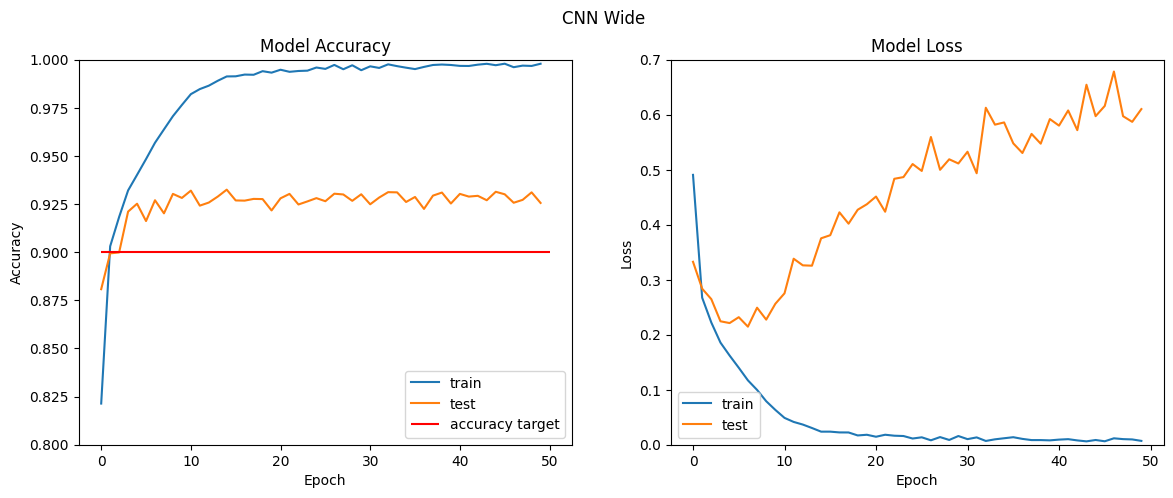

In [22]:
show_history(history_cnn_wide, "CNN Wide")

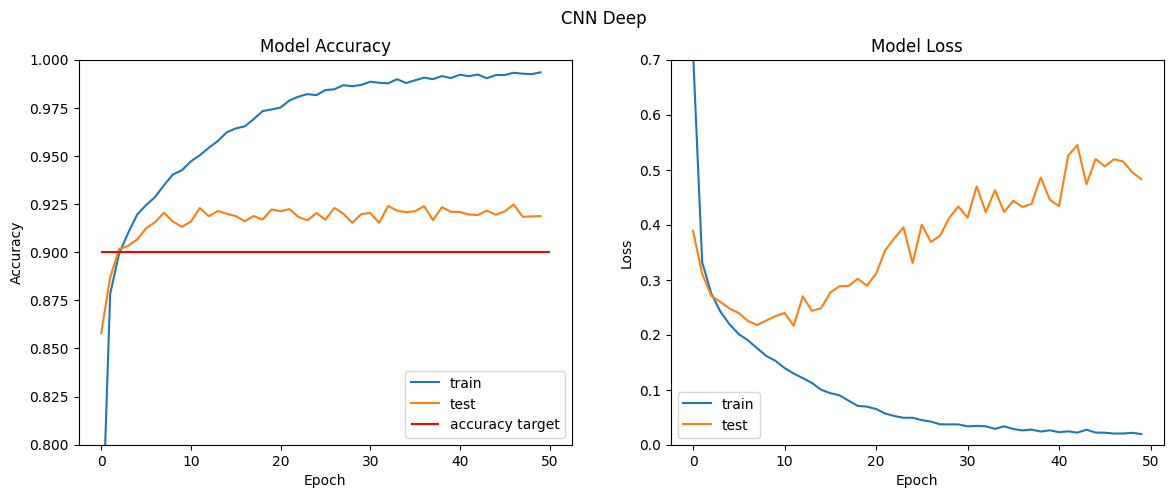

In [23]:
show_history(history_cnn_deep, "CNN Deep")

С помощью сверточных нейронных сетей удалось добиться более высоких значений метрики Accuracy примерно 92% по сравнению с полносвязанными моделями. Также на рисунке выше можно видеть, что "широкая" сверточная модель позволяет получить немного большие значения метрики, но при этом имеет большую склонность к переобучению, в отличие от "глубокой".

## Метрики классификации

Рассмотрим метрики классификации, получаемые с помощью "глубокой" сверточной нейронной сети (данная архитектура выбрана из-за меньшей склонности к переобучению). 

In [24]:
def show_report(test_labels, test_preds, classes_names):
    # Построение матрицы ошибок
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes_names,
        yticklabels=classes_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Отчет о классификации
    print(f"Classification Report")
    print(
        classification_report(
            test_labels, test_preds, target_names=classes_names
        )
    )

313/313 [==============================] - 1s 3ms/step


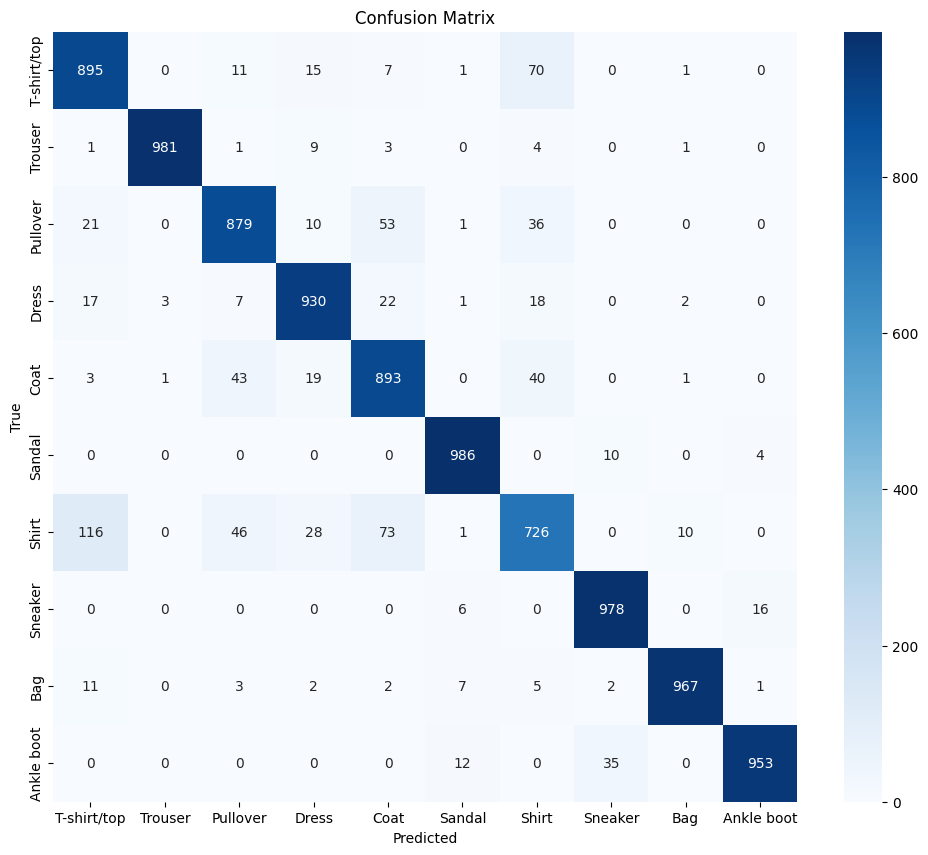

Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.90      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.89      0.88      0.88      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.85      0.89      0.87      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.81      0.73      0.76      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [25]:
test_preds = np.argmax(model_cnn_deep.predict(X_test), axis=-1)
classes_names = [label_description[i] for i in range(N_CLASSES)]
show_report(y_test, test_preds, classes_names)

Метрики классификации (f1-score) для каждого из классов немного отличаются, хуже всего модель справляется с классами Shirt, T-Shirt/Top, а лучше всего с классами Trouser, Sandal, Bag.

## Получение предсказания

Получим предсказание для изображения с помощью "глубокой" сверточной нейронной сети (данная архитектура выбрана из-за меньшей склонности к переобучению).

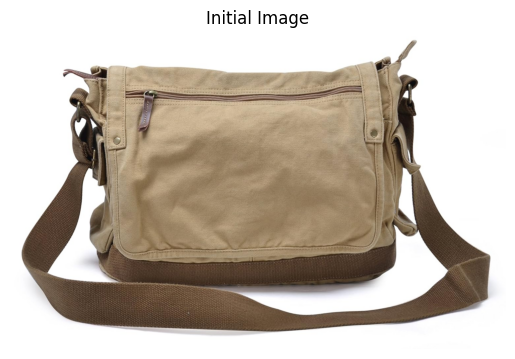

In [26]:
image = cv2.imread("./bag.jpg")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Initial Image")
plt.axis("off")
plt.show()

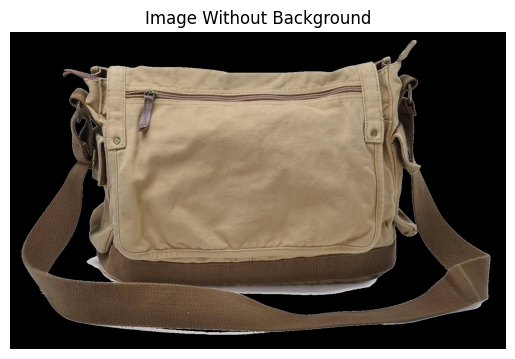

In [27]:
def remove_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)
    mask = cv2.bitwise_not(thresh)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result


image = remove_background(image)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image Without Background")
plt.axis("off")
plt.show()

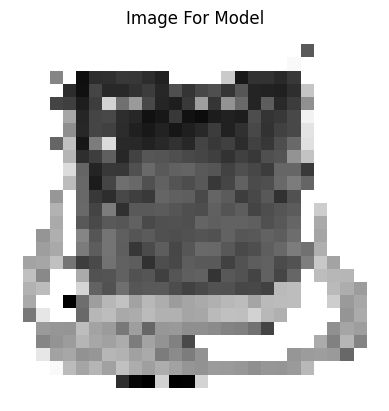

In [28]:
# Преобразование в черно-белое изображение
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Изменение размера
image = cv2.resize(image, (28, 28))
# Нормализация изображения к диапазону [0, 1]
image = (image / image.max()).astype("float32")

plt.imshow(image, cmap="binary")
plt.title("Image For Model")
plt.axis("off")
plt.show()

In [29]:
prediction = model_cnn_deep.predict(np.expand_dims(image, axis=0))
prediction = label_description[np.argmax(prediction)]
prediction

1/1 [==============================] - 0s 66ms/step


'Bag'

Модель справилась с задачей и корректно определила класс изображения - "Bag", несмотря на то, что после преобразования в формат, пригодный для использования моделью, было утерено большое количество деталей.

## Выводы
- С помощью сверточных нейронных сетей удалось добиться значения Accuracy в 92% при классификации изображений датасета fashion_mnist. Полученное значение укладывается в установленный задачей порог - 90%
- Показано, что "глубокая" полносвязанная и "широкая" сверточная нейронные сети имеют большую склонность к переобучению.
- Показано, что метрика f1-score для каждого класса изображений отличается, хуже всего модель справляется с классификацией Shirt, T-Shirt/Top, а лучше всего с Trouser, Sandal, Bag.
- С помощью обученной модели удается корректно классифицировать вещь на фотографии.